In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz,pickle, yaml
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr, concat, drone, bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
import beamcals.reduce_ccclass as rc
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

#Epols = [0,3,4,7,9,10,12,14]
#Npols = [1,2,5,6,8,11,13,15]

Epols = [0,2,4,6,8,10,12,14]
Npols = [1,3,5,7,9,11,13,15]
config_directory="/hirax/GBO_Analysis_Outputs/concat_config_files/"

# dishes are 2n, 2n+1 pairs

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

20211020T215911Z /hirax/GBO_Oct_2021/TONE_ACQ/20211020T215858Z_yale_drone/corr/20211020T215911Z/ /hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/20211020T215858Z_yale_drone_yale_digitalgain/
Initializing drone data via datcon_csv routine: FLY608.csv
  --> Skipping rows 1 to 499 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK Data not found for this data file...
  --> Loading position data from GPS(0) instead:
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.
DONE reading in drone data
2021-10-20 22:01:03.800000+00:00 2021-10-20 22:12:56.996000+00:00


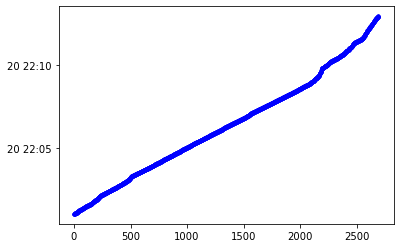

plotting drone coordinates for all time samples:
overplotting drone coordinates for t_cut samples: [0:-1]
start time:  2024-03-15 15:02:35.596023
Initializing Correlator Class using:
  --> /hirax/GBO_Oct_2021/TONE_ACQ/20211020T215858Z_yale_drone/corr/20211020T215911Z/
  --> Arrays initialized with shape (60, 256, 1024, 16)
Assigning array values by reading in data files:
  --> Loading File: 0059/0059
  --> Finished. Reshaping arrays.
end time:  2024-03-15 15:08:17.611682


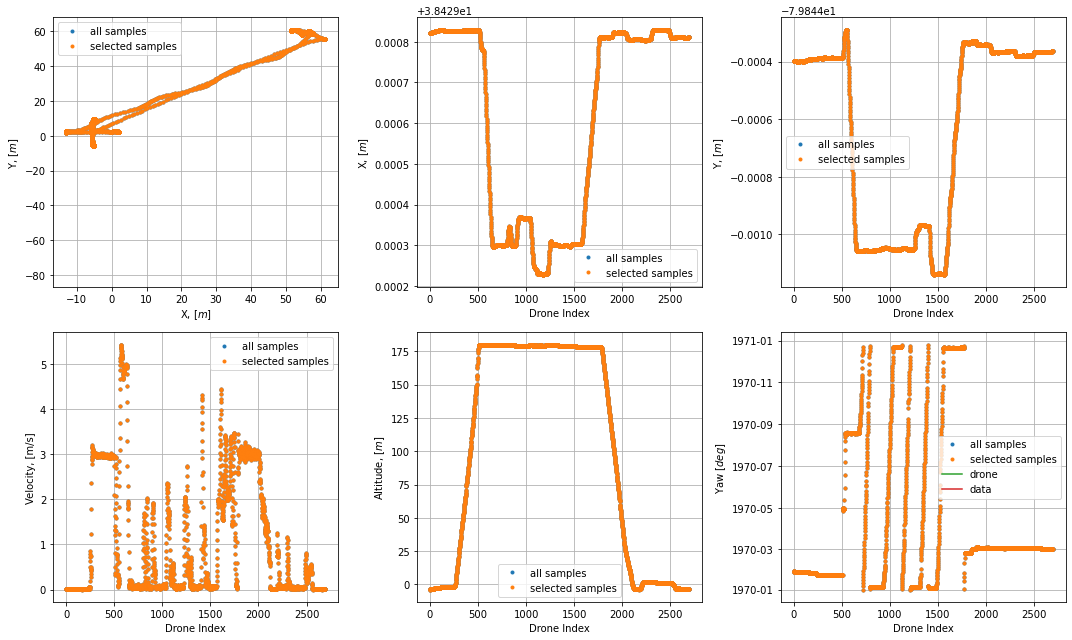

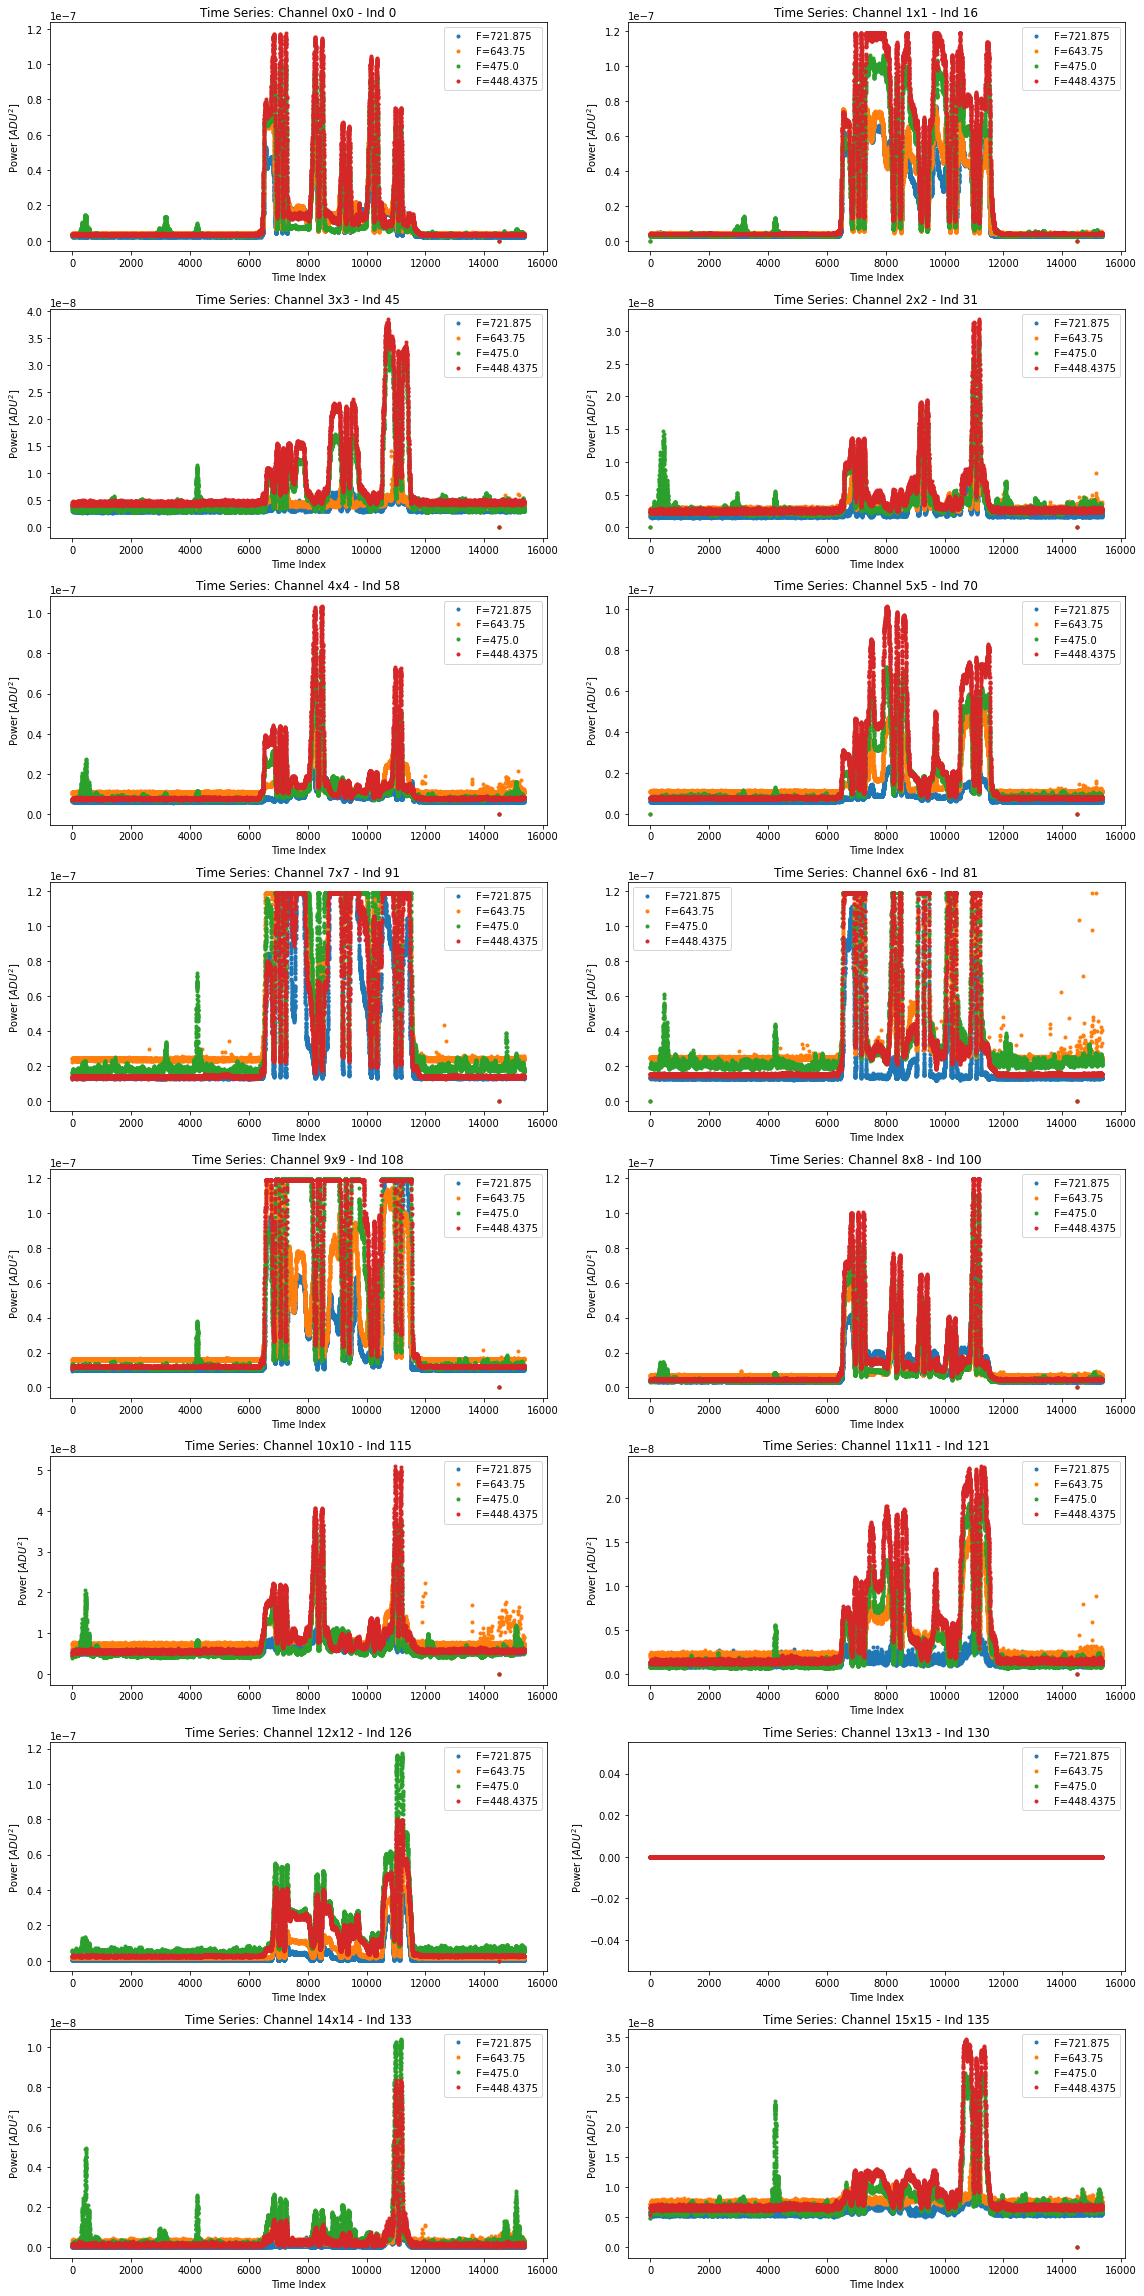

In [2]:
# Read the yaml for the flight you're interested in:
fly = '608'
cdat = '20211020T215858Z'

if int(fly) < 537:
    mdir='/hirax/GBO_Aug_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # August 2021
    gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
else:
    mdir='/hirax/GBO_Oct_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # Oct 2021
    gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021

sdir = os.listdir(mdir)[0]
datadir=mdir+sdir+'/'
print(sdir, datadir,gaindir)
    
dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite,tlb=0,tub=-1)

print('DONE reading in drone data')
print(dronetest0825.t_arr_datetime[0], dronetest0825.t_arr_datetime[-1])


plt.plot(dronetest0825.t_arr_datetime,'b.',label='drone')
plt.show()

pu.Plot_Drone_Coordinates(dronetest0825,coo='xy')#,t_bounds=[tlb,tub])
#pu.Plot_Drone_Coordinates(dronetest0825,coo='xy',t_bounds=[tlb,tub])


## Combine drone and correlator data
print('start time: ', datetime.datetime.now())
corrtest0825=corr.Corr_Data(Data_Directory=datadir,
                            Gain_Directory=gaindir,site_class=gbosite,
                            crossmap=[])
#

    
print('end time: ', datetime.datetime.now())

# putting checks in one cell now that I know I've mostly figured out the flight/corr file correspondence
# This checks I copied and pasted ok :)

## plot their datetime arrays to check overlap:

plot(dronetest0825.t_arr_datetime,label='drone')
plot(corrtest0825.t_arr_datetime,label='data')
legend()


config_directory="/hirax/GBO_Analysis_Outputs/concat_config_files/"

concattest=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,\
                             load_yaml=False,traceback=False,save_traceback=False)
#concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,load_yaml=True,
#                             traceback=False,save_traceback=False)

pu.Plot_Time_Series(concattest,freqlist=[200,400,832,900]) # previously set to just 700

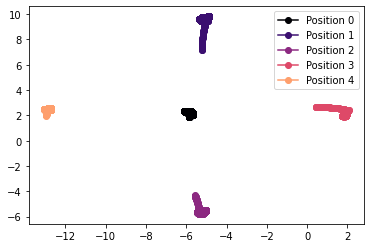

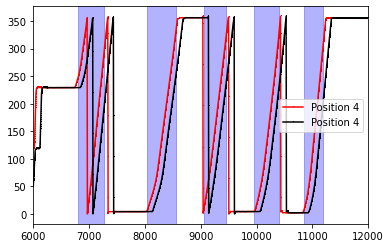

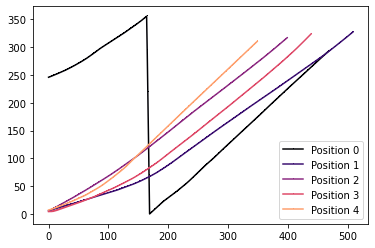

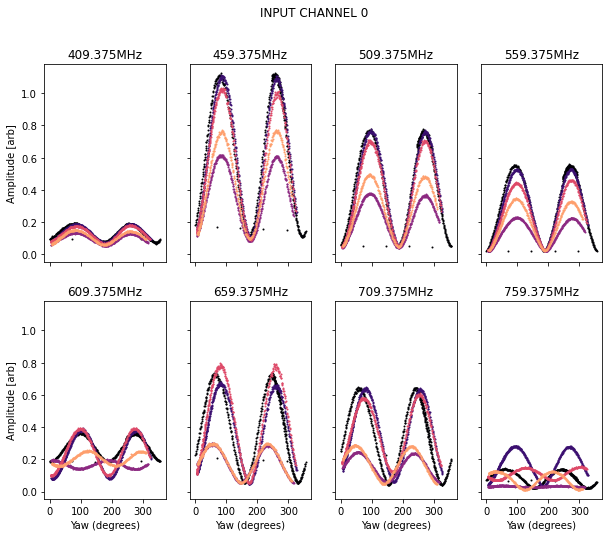

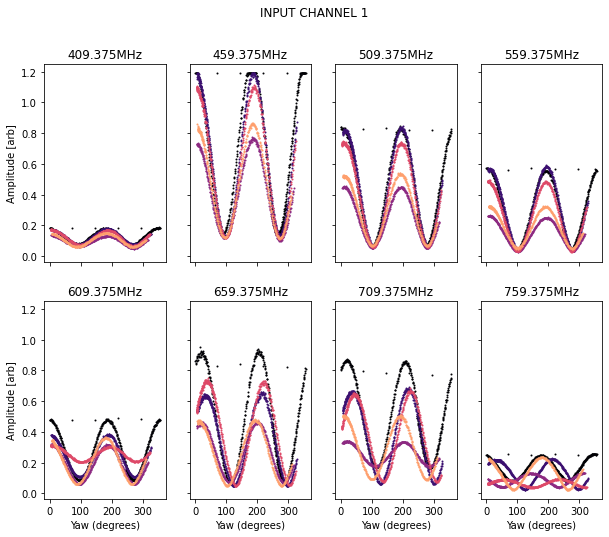

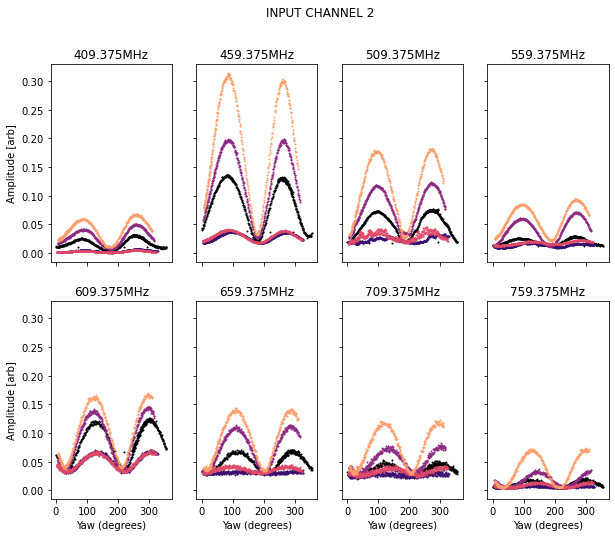

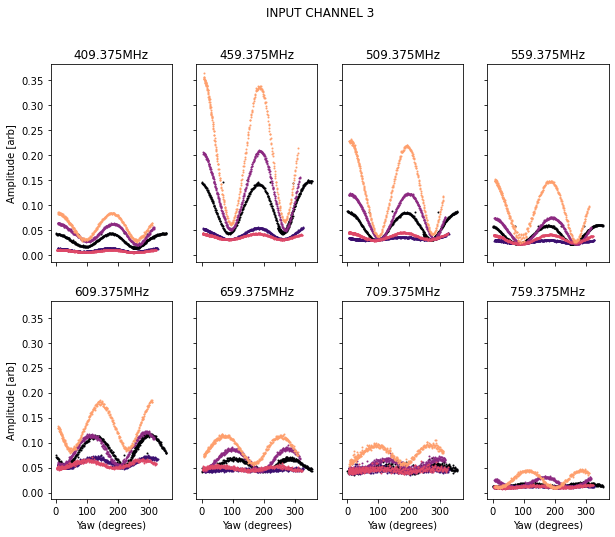

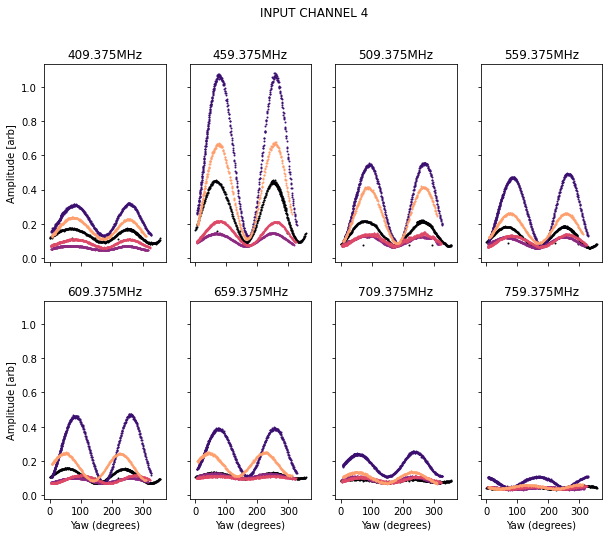

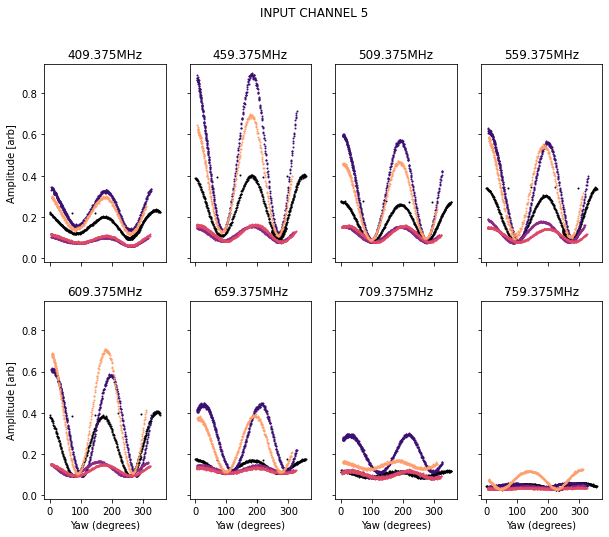

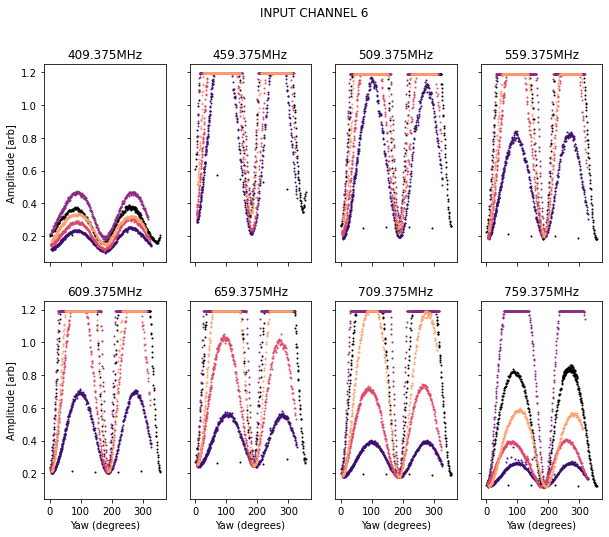

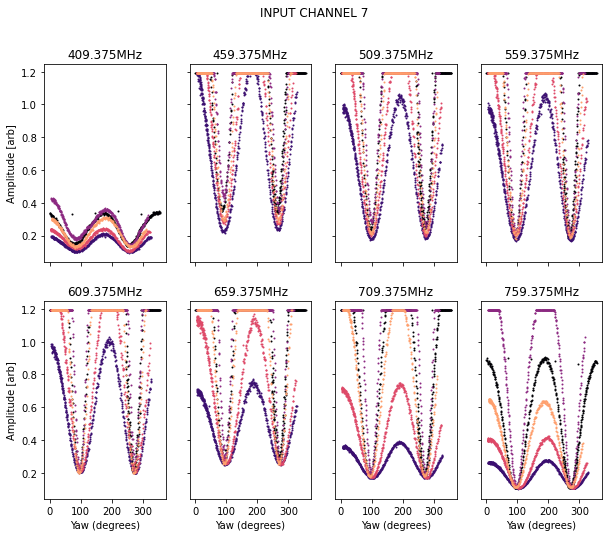

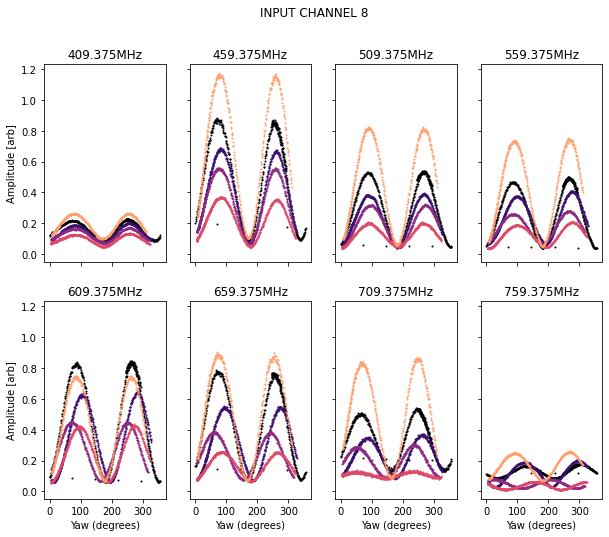

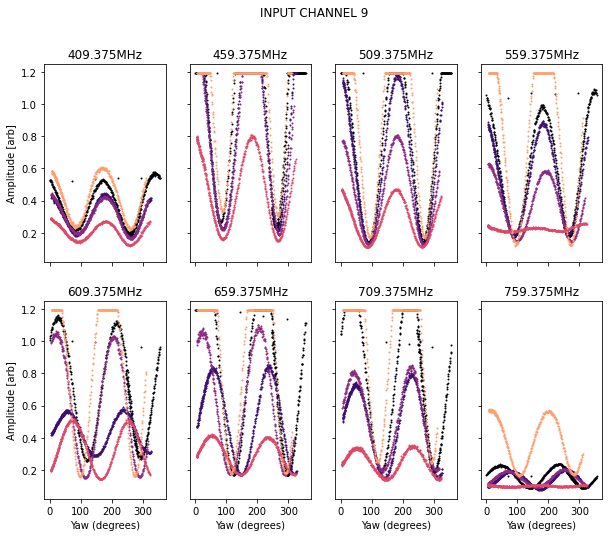

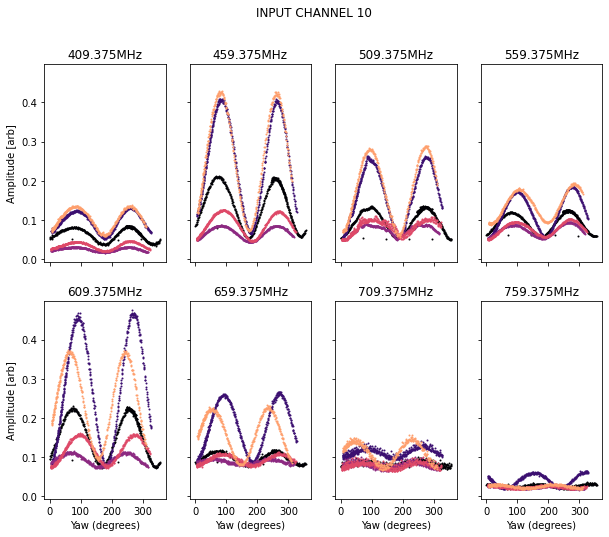

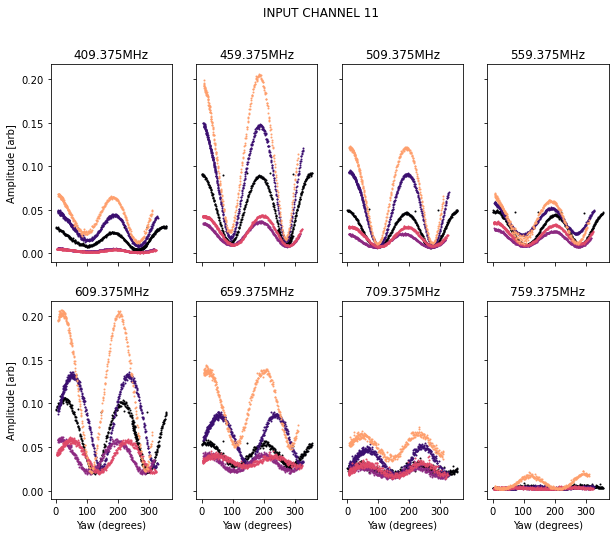

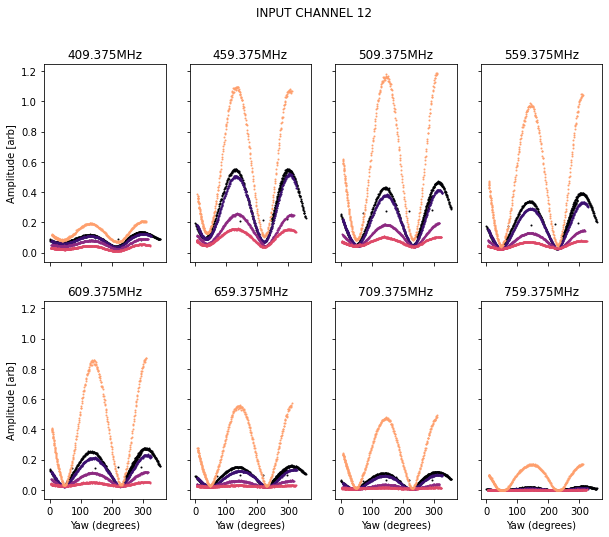

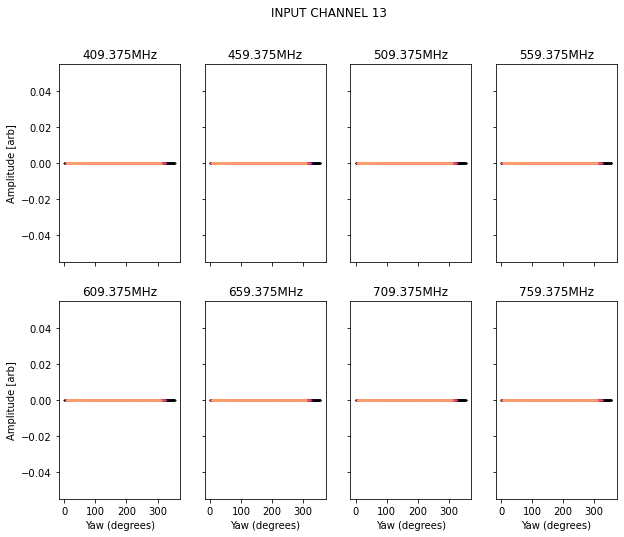

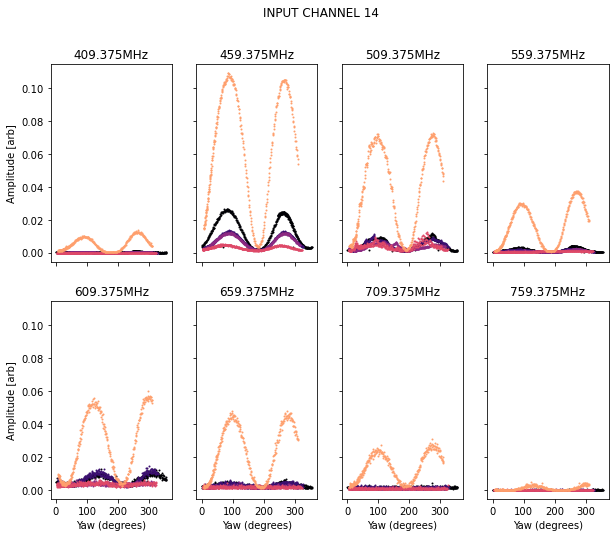

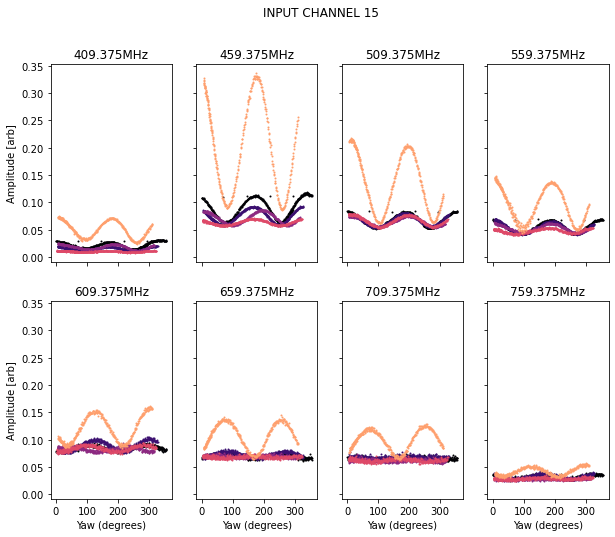

In [3]:
# Through various machinations, we have these indices for the rotation components:

ccm = cm.magma # use magma for color maps
colorz=pu.cm_to_discrete(ccm,5)

# First, note that the drone and telescope time stamps are not aligned. We change by eye, by
# moving the drone stime stamps back by 100 samples:

nn = -100
shiftedyaw = np.roll(concattest.drone_yaw_interp,nn)

pos0 = np.arange(6900+nn, 7370+nn)
pos1 = np.arange(8140+nn,8650+nn)
pos2 = np.arange(9150+nn,9550+nn)
pos3 = np.arange(10060+nn,10500+nn)
pos4 = np.arange(10950+nn,11300+nn)


poss = [pos0,pos1,pos2,pos3,pos4]
lp = 5

# Plot positions in X,Y 
for k in np.arange(5):
    plot(concattest.drone_xyz_LC_interp[poss[k],0], concattest.drone_xyz_LC_interp[poss[k],1], 
         marker='o',color=colorz[k],label='Position '+str(k))
plt.legend()
plt.show()

# Plot yaw and shifted yaw
plot(np.arange(len(concattest.drone_yaw_interp)),shiftedyaw,marker=',',color='red',label='Position '+str(k))
plot(np.arange(len(concattest.drone_yaw_interp)),concattest.drone_yaw_interp,marker=',',color='black',label='Position '+str(k))
for k in np.arange(5):
    plt.axvspan(poss[k][0],poss[k][-1],color='blue',alpha=0.3)
plt.legend()
plt.xlim(6000,12000)
plt.show()

# Plot yaw for each segment
for k in np.arange(5):
    plot(shiftedyaw[poss[k]],marker=',',color=colorz[k],label='Position '+str(k))
plt.legend()
plt.show()


# Plot telescope signal as a funciton of yaw
for pol in np.arange(0,16):

    fig,axs = plt.subplots(2, 4, sharex=True,sharey=True,figsize=(10,8))
    for i, freq in enumerate(np.arange(1000,0,-128)):      
        for k in np.arange(5):
            if i<4: 
                r = 0
                c = i
            else:
                r = 1
                c = i-4
            axs[r,c].plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],freq,pol]), '.', markersize = 2,color=colorz[k])
            axs[r,c].set_title(str(freqs[freq])+'MHz')
    axs[0,0].set_ylabel('Amplitude [arb]')
    axs[1,0].set_ylabel('Amplitude [arb]')
    axs[1,0].set_xlabel('Yaw (degrees)')
    axs[1,1].set_xlabel('Yaw (degrees)')
    axs[1,2].set_xlabel('Yaw (degrees)')
    axs[1,3].set_xlabel('Yaw (degrees)')
    fig.suptitle('INPUT CHANNEL '+str(pol))

    fig.show()






In [4]:
# Notes about channels:
#0/1 : normal keep; here ok 
#2/3 : normal keep; here ok
#4/5 : usually mixed co/cross so removed in regular analysis; here ok but skip anyway
#6/7 : no good amplitude fits, but these are CHIME channels ; have to keep but not all locations are good
#8/9 : input 9 saturated for all flights, removed companion 8 as well ; saturated here too
#10/11 : normal keep ; here ok
#12/13 : usually mixed co/cross so removed in regular analysis; 13 is clock
#14/15 : normal keep ; here ok



goodpols = [0,1,2,3,10,11,14,15]
chimepols = [6,7]
allgoodpols = [0,1,2,3,6,7,10,11,14,15]
N_pols = [1,3,7,11,15]
E_pols = [0,2,6,10,14]



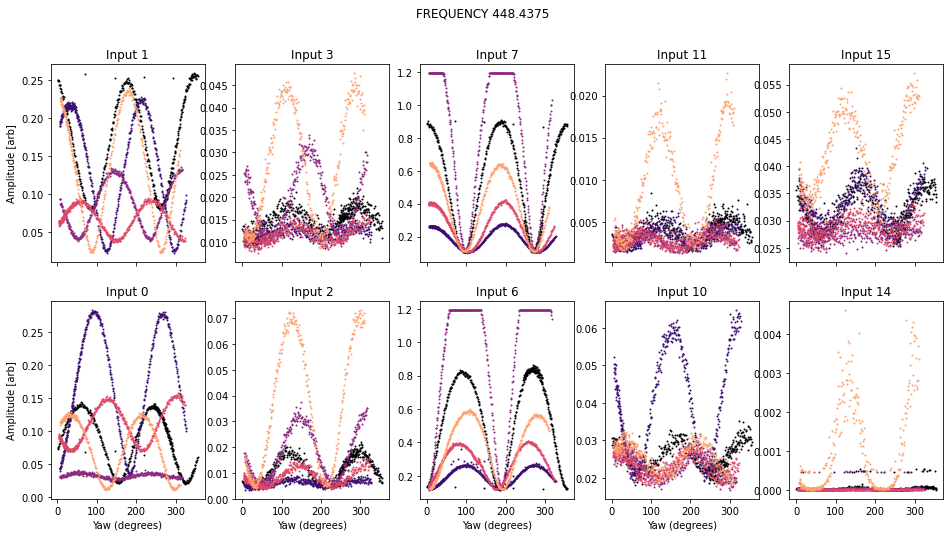

In [5]:
fig,axs = plt.subplots(2,5, sharex=True,figsize=(16,8))
find = 900
for p,chind in enumerate(N_pols):
    for k in np.arange(lp):
        axs[0,p].plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],freq,chind]), '.', 
                      markersize = 2,color=colorz[k],label='loc'+str(k))
        axs[0,p].set_title('Input '+str(chind))
for p,chind in enumerate(E_pols):
    for k in np.arange(lp):
        axs[1,p].plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],freq,chind]), '.', 
                      markersize = 2,color=colorz[k],label='loc'+str(k))
        axs[1,p].set_title('Input '+str(chind))
axs[0,0].set_ylabel('Amplitude [arb]')
axs[1,0].set_ylabel('Amplitude [arb]')
axs[1,0].set_xlabel('Yaw (degrees)')
axs[1,1].set_xlabel('Yaw (degrees)')
axs[1,2].set_xlabel('Yaw (degrees)')
axs[1,3].set_xlabel('Yaw (degrees)')
fig.suptitle('FREQUENCY '+str(freqs[find]))

fig.show()

In [6]:
def sin_fun(x,*params):
    [a,b,c,d] = params 
    return a*np.sin(b*x*np.pi/180-c*np.pi/180)+d   

def cos_fun(x,*params):
    
    [a,b,c,d] = params   
    return a*np.cos(b*(np.radians(x)-c))+d 

def cos2_fun(x,*params):
    
    [a,b,c,d] = params   
    return a*(np.cos(b*(np.radians(x)-c)))**2 + d 

(1.185e-07, 1.2e-07)

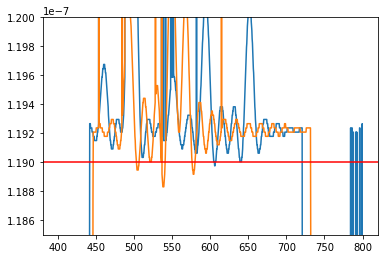

In [7]:
plt.plot(freqs,np.max(concattest.V[poss[0],:,6],axis=0))
plt.plot(freqs,np.max(concattest.V[poss[0],:,7],axis=0))
plt.axhline(1.19E-7,color='red')
plt.ylim(1.185E-7,1.2E-7)

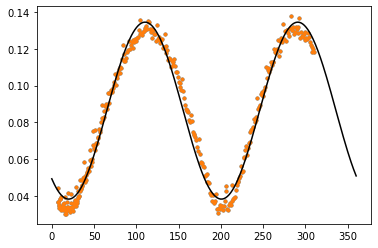

[ 0.096092    0.99604363 -1.2299674   0.03836424]
0.11030351743102074
[0.04055672 0.99376466 1.29542109 0.06122983]


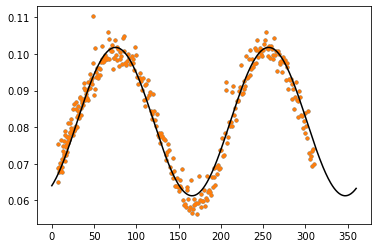

[ 0.04055672  0.99376466 -1.84617157  0.06122983] [ 0.04055672  0.99376466 -1.84617157  0.06122983]


In [8]:
# Lets try fitting a sine to the CHIME inputs, we'll start with position 4

# Amplitude to be positive; period shoudl be around 1;
#phase should be between 0 and pi, offset can be whatever

bnds = ((0, 0.5,-np.pi/2, -np.inf),(2.0, 1.5,np.pi, np.inf))
pG = [1.0,1.0,0,0.1]
poss = [pos4]
find = 321
chind = 2

plt.plot(shiftedyaw[poss[0]], 
        1e7*(concattest.V[poss[0],find,chind]),marker='.',linestyle='None')

gi = np.where(1e7*(concattest.V[poss[0],find,chind]) < 1.19)[0]
plt.plot(shiftedyaw[poss[0][gi]], 
        1e7*(concattest.V[poss[0][gi],find,chind]),marker='.',linestyle='None')


popt, pcov = opt.curve_fit(cos2_fun, shiftedyaw[poss[0][gi]], \
                               1e7*(concattest.V[poss[0][gi],find,chind]), p0=pG,bounds=bnds)
plot(np.linspace(0,360,360), cos2_fun(np.linspace(0,360,360), *popt), 'k')

plt.show()

print(popt)


poss = [pos4]
chind = 3

plt.plot(shiftedyaw[poss[0]], 
        1e7*(concattest.V[poss[0],find,chind]),marker='.',linestyle='None')

print(max(1e7*(concattest.V[poss[0],find,chind])))

# For this channel, the max seems to be 1.191

gi = np.where(1e7*(concattest.V[poss[0],find,chind]) < 1.19)[0]

plt.plot(shiftedyaw[poss[0][gi]], 
        1e7*(concattest.V[poss[0][gi],find,chind]),marker='.',linestyle='None')

popt, pcov = opt.curve_fit(cos2_fun, shiftedyaw[poss[0][gi]], \
                               1e7*(concattest.V[poss[0][gi],find,chind]), p0=pG,bounds=bnds)
print(popt)
pnew = popt
pnew[2] = popt[2]-np.pi
plot(np.linspace(0,360,360), cos2_fun(np.linspace(0,360,360), *pnew), 'k')

plt.show()

print(popt,pnew)

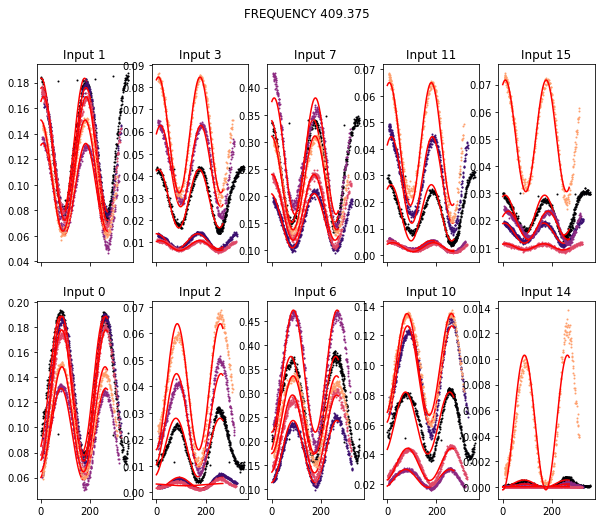

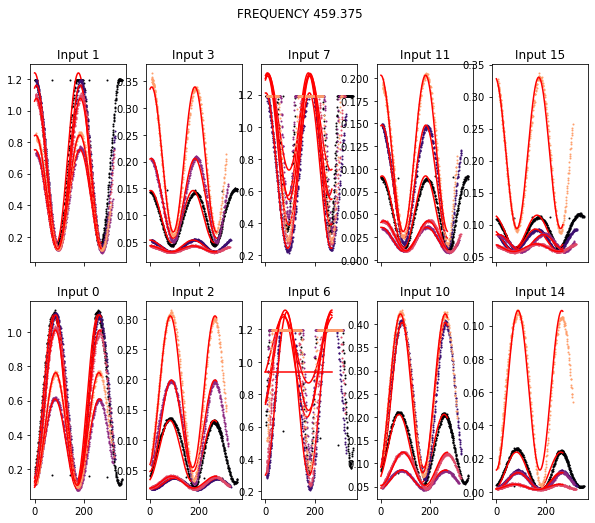

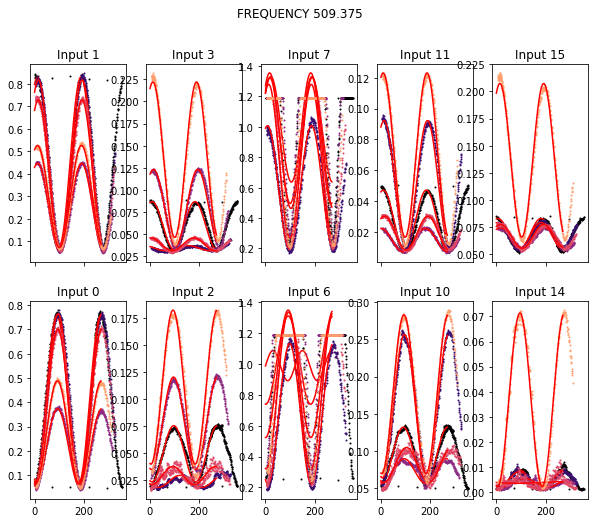

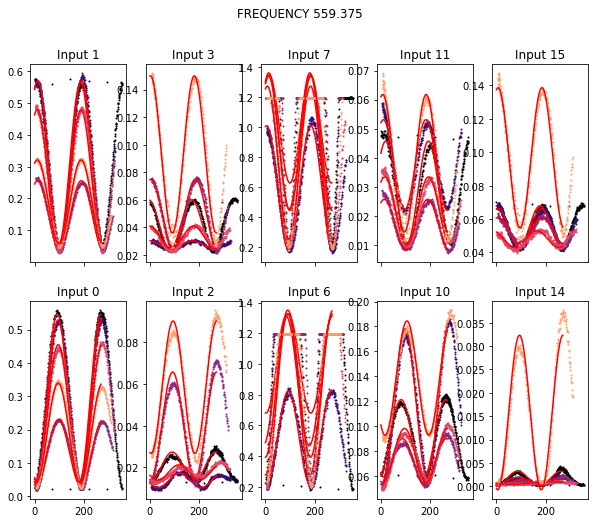

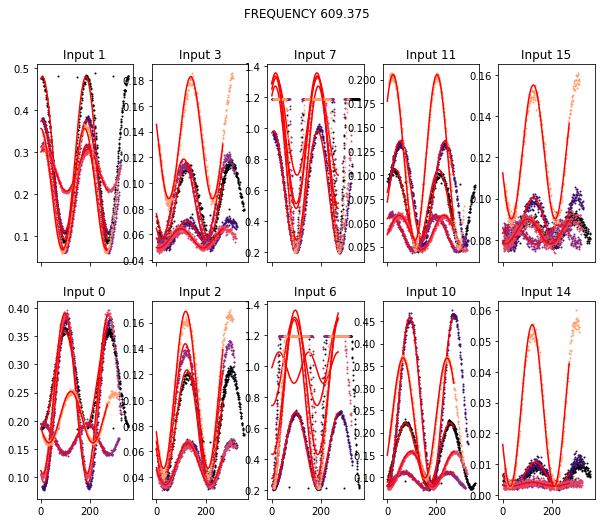

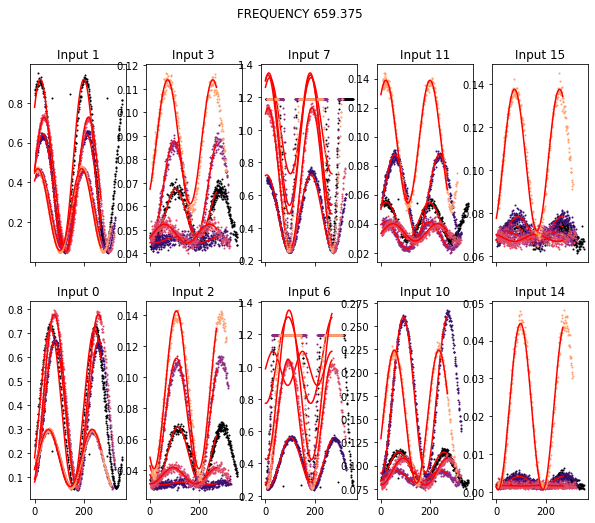

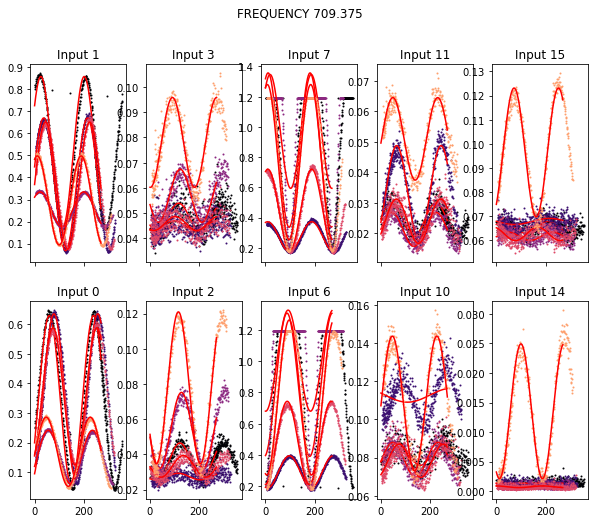

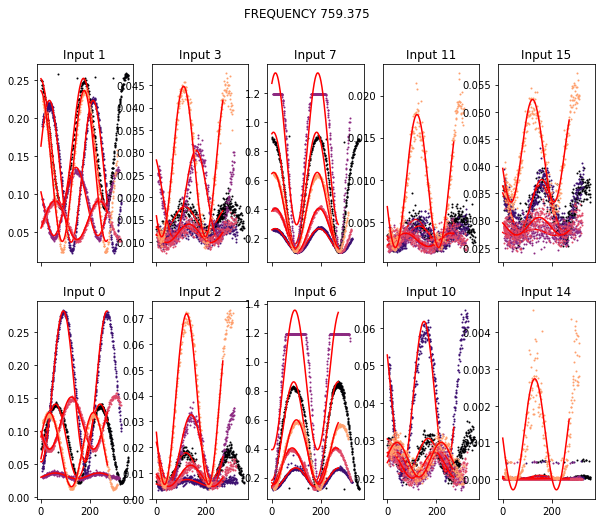

In [9]:
poss = [pos0,pos1,pos2,pos3,pos4]
lp = 5

for i, find in enumerate(np.arange(1000,0,-128)): 
    fig,axs = plt.subplots(2,5, sharex=True,figsize=(10,8))
    for p,chind in enumerate(N_pols):
        for k in np.arange(lp):
            axs[0,p].plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],find,chind]), '.', 
                      markersize = 2,color=colorz[k],label='loc'+str(k))
            try:
                gi = np.where(1e7*(concattest.V[poss[k],find,chind]) < 1.191)[0]
                popt, pcov = opt.curve_fit(cos2_fun, shiftedyaw[poss[k]], \
                        1e7*(concattest.V[poss[k],find,chind]), p0=pG,bounds=bnds)
                axs[0,p].plot(np.linspace(0,270,270), cos2_fun(np.linspace(0,270,270), *popt), 'r')
            except:''
            axs[0,p].set_title('Input '+str(chind))
    for p,chind in enumerate(E_pols):
        for k in np.arange(lp):
            axs[1,p].plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],find,chind]), '.', 
                      markersize = 2,color=colorz[k],label='loc'+str(k))
            try:
                gi = np.where(1e7*(concattest.V[poss[k],find,chind]) < 1.191)[0]
                popt, pcov = opt.curve_fit(cos2_fun, shiftedyaw[poss[k]], \
                        1e7*(concattest.V[poss[k],find,chind]), p0=pG,bounds=bnds)
                axs[1,p].plot(np.linspace(0,270,270), cos2_fun(np.linspace(0,270,270), *popt), 'r')
            except:''
            axs[1,p].set_title('Input '+str(chind))
    fig.suptitle('FREQUENCY '+str(freqs[find]))

    fig.show()

In [10]:
## Fit just position #4 (highest SNR)
poss = [pos4]
lp = 1
fits = np.zeros((4,lp,16,1024))
#bnds = ((0, 0.5,-np.pi, -np.inf),(2.0, 1.5,np.pi, np.inf)) # force amplitude to be positive, maybe makes the fits take forver

for fi,find in enumerate(np.arange(0,1024)):
    for p,chind in enumerate(allgoodpols):
    #for p,chind in enumerate(chimepols):
        for k in np.arange(lp):
            try:
                gi = np.where(1e7*(concattest.V[poss[k],find,chind]) < 1.19)[0]
                popt, pcov = opt.curve_fit(cos2_fun, shiftedyaw[poss[k][gi]], \
                        1e7*(concattest.V[poss[k][gi],find,chind]), p0=pG,bounds=bnds)
                fits[:,k,chind,find] = popt
            except:''

ffreq ind  1
CHIND1  [ 5.77498996e-03  1.01985524e+00 -9.77599720e-01 -3.48512213e-04] phase angle:  -56.01233798696114
CHIND2  [ 0.00711548  1.01045902 -1.29113143  0.00151943] phase angle:  -73.97638166742284
CHINE1 - CHIND2  17.9640436804617


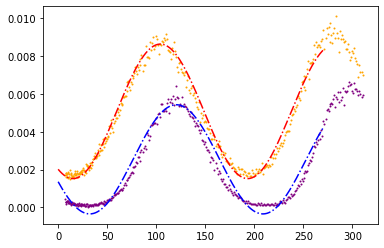

ffreq ind  129
CHIND1  [ 0.07248924  1.00476956 -0.99441642  0.0076365 ] phase angle:  -56.97586421586088
CHIND2  [ 0.03813667  1.0120386  -1.22910933  0.01428941] phase angle:  -70.42277711098554
CHINE1 - CHIND2  13.44691289512465


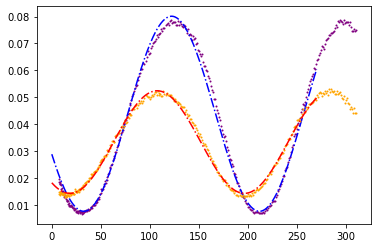

ffreq ind  257
CHIND1  [ 0.08529665  1.00413334 -1.17253708  0.02643105] phase angle:  -67.18142613172213
CHIND2  [ 0.03745546  1.00762377 -1.57079633  0.04878868] phase angle:  -89.99999999988556
CHINE1 - CHIND2  22.81857386816343


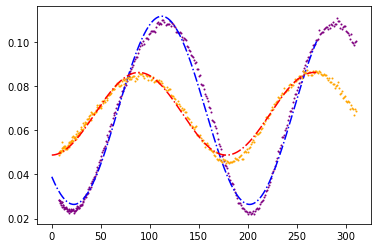

ffreq ind  385
CHIND1  [ 0.11683032  0.98624915 -1.37284319  0.03122204] phase angle:  -78.65812074304095
CHIND2  [0.06226738 0.97565548 1.30516485 0.04766684] phase angle:  74.7804374412773
CHINE1 - CHIND2  -153.43855818431825


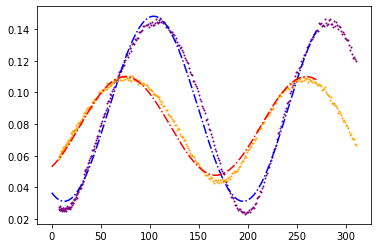

ffreq ind  513
CHIND1  [ 0.06200583  1.00296871 -1.11133949  0.03650362] phase angle:  -63.67506217373159
CHIND2  [ 0.08650471  1.02161255 -0.41507714  0.06143341] phase angle:  -23.78216807802414
CHINE1 - CHIND2  -39.89289409570745


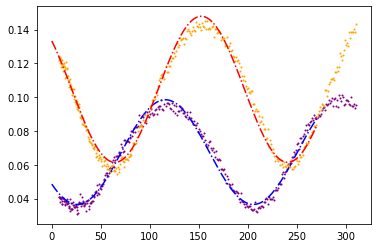

ffreq ind  641
CHIND1  [ 0.08877753  1.00454446 -1.57079633  0.05187347] phase angle:  -89.99999999999999
CHIND2  [0.1306664  1.00341968 0.13138726 0.06216915] phase angle:  7.527935609986494
CHINE1 - CHIND2  -97.52793560998647


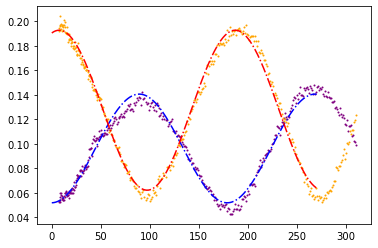

ffreq ind  769
CHIND1  [ 0.19397856  1.00072389 -1.5080534   0.05986384] phase angle:  -86.40509481665221
CHIND2  [0.2321858  1.0134567  0.14675918 0.06744721] phase angle:  8.408681553576828
CHINE1 - CHIND2  -94.81377637022904


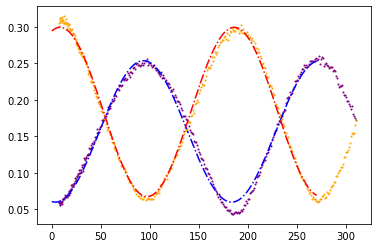

ffreq ind  897
CHIND1  [ 0.24964515  0.99979934 -1.51183366  0.06802764] phase angle:  -86.62168808627848
CHIND2  [0.23638793 1.02706621 0.23645959 0.08707539] phase angle:  13.548136587451802
CHINE1 - CHIND2  -100.16982467373028


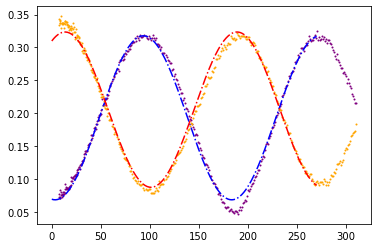

In [11]:
# Let's just look at CHIME fits:
k=0
chind1 = 2
chind2 = 3
for fi,find in enumerate(np.arange(1,1024,128)):
    print('ffreq ind ',find)
    plt.plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],find,chind1]), '.', 
                      markersize = 2,color='purple',label='input '+str(chind1))
    popt1 = fits[:,k,chind1,find]
    print('CHIND1 ',popt1,'phase angle: ',(180/np.pi)*popt1[2])
    plt.plot(np.linspace(0,270,270), cos2_fun(np.linspace(0,270,270), *popt1), color='blue',linestyle='-.')
    plt.plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],find,chind2]), '.', 
                      markersize = 2,color='orange',label='input '+str(chind2))
    popt2 = fits[:,k,chind2,find]
    plt.plot(np.linspace(0,270,270), cos2_fun(np.linspace(0,270,270), *popt2), color='red',linestyle='-.')
    print('CHIND2 ',popt2,'phase angle: ',(180/np.pi)*popt2[2])
    print('CHINE1 - CHIND2 ',(180/np.pi)*(popt1[2] - popt2[2]))
    plt.show()

Text(400, 175, 'CHIME FEED')

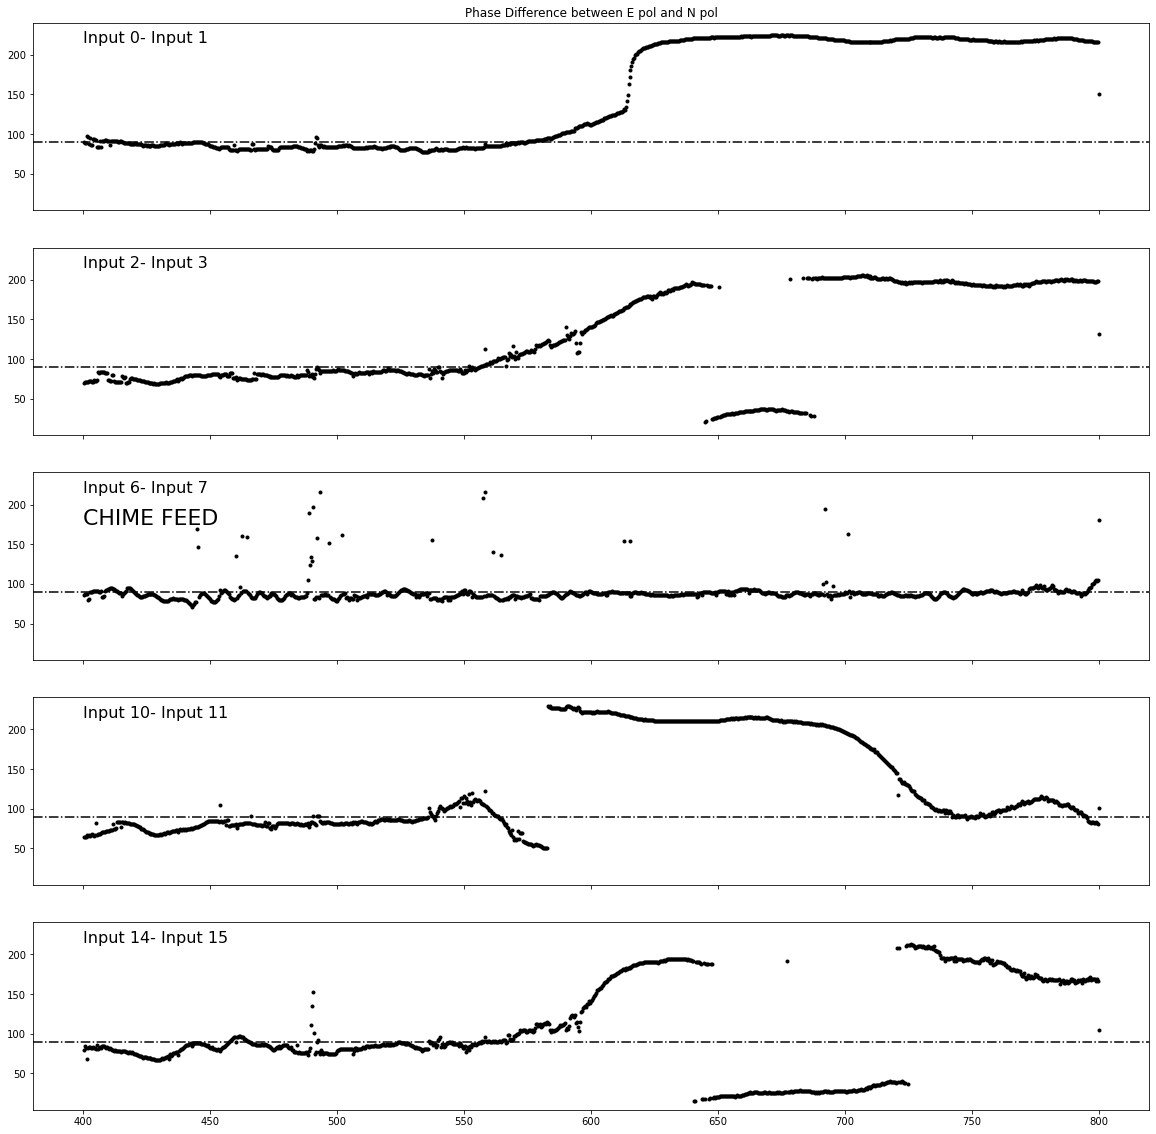

In [12]:

fig,axs = plt.subplots(5, sharex=True,sharey=True,figsize=(20,20))
#for fi in np.arange(len(fits[:,0,0,0])): # fit param
fi = 2
k = 0#4
lp = 1
badfreqs=[]

for p,chind in enumerate(E_pols):
    esig = fits[fi,k,chind,:]
    nsig = fits[fi,k,chind+1,:]
    diff = (180/np.pi)*(esig-nsig)+180
    #axs[p].plot(freqs,diff,
    #              color='red',marker='s',markersize=7,linestyle='None',label='orig')

    for i in np.arange(0,1024):
        if diff[i] > 230: diff[i] = diff[i]-180
        if diff[i] > 100: badfreqs.append(i)
    axs[p].plot(freqs,diff,
                  color='black',marker='.',linestyle='None')
    #axs[p].set_ylim(0,4.5)
    axs[p].text(400,215,'Input '+str(chind)+'- Input '+str(chind+1),fontsize=16)
    axs[p].axhline(90,color='black',ls='-.')
    #axs[p].axhline(0.0,color='yellow')
axs[0].set_title('Phase Difference between E pol and N pol')
axs[2].text(400,175,'CHIME FEED',fontsize=22)
    


East pol:  0 [-90.         -90.          82.35901205  81.77139156 -90.
  81.73237695 -90.         -90.          81.9743172   81.30909386]
Nort pol:  1 [-3.2955989  -3.41938753 -4.10371226 -4.81644875 -5.07985174 -5.93752996
 -6.46925896 -7.76393183 -6.77705832 -7.71719654]
East pol:  2 [79.17200268 78.17549127 77.67586087 77.8720197  77.99476353 77.44985082
 75.74245617 75.68584679 75.25217347 75.3304281 ]
Nort pol:  3 [6.35163897 6.65955235 6.4947391  5.87645346 5.98549803 5.22111534
 4.74947139 4.33572844 4.01566495 4.66080812]
East pol:  6 [-90.         -90.         -90.         -90.         -90.
  82.49385569  81.78656963 -90.         -90.         -90.        ]
Nort pol:  7 [-0.86365112 -0.84036703 -0.22060423  0.34028359  0.67089497  1.33664165
  1.73279622  2.39611411  3.25666419  3.25321627]
East pol:  10 [74.45345825 74.32042654 74.12002721 73.63657049 73.11575156 71.60211763
 70.71679329 71.44820017 71.00054132 70.22244803]
Nort pol:  11 [8.58883148 7.52781433 6.41885991 6.791

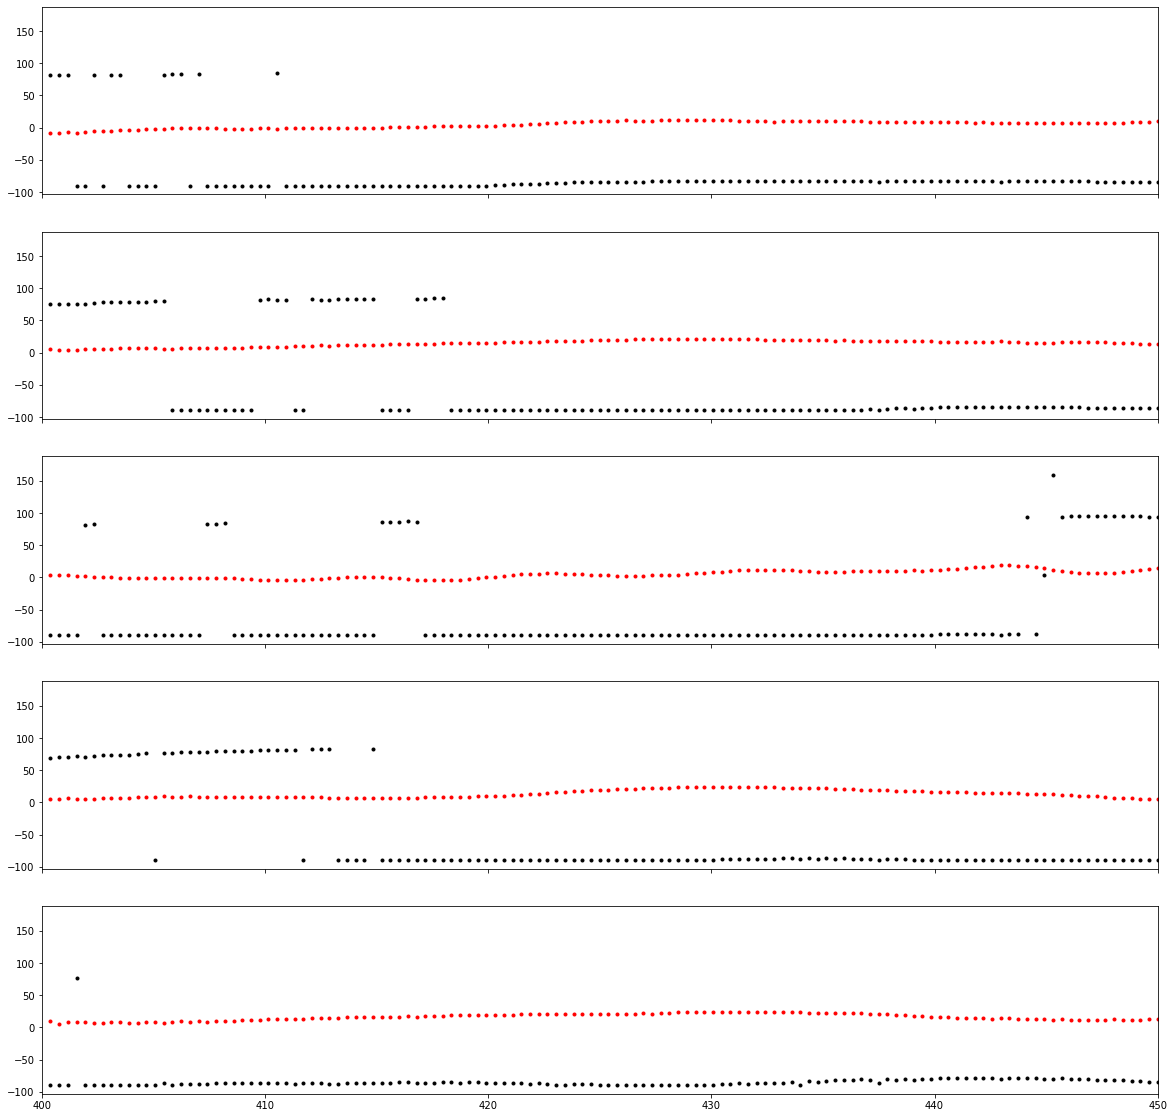

In [14]:
fig,axs = plt.subplots(5, sharex=True,sharey=True,figsize=(20,20))
#for fi in np.arange(len(fits[:,0,0,0])): # fit param
fi = 2
k = 0#4
lp = 1
badfreqs=[]

for p,chind in enumerate(E_pols):
    esig = fits[fi,k,chind,:]
    nsig = fits[fi,k,chind+1,:]

    axs[p].plot(freqs,np.degrees(esig),
                  color='black',marker='.',linestyle='None')
    axs[p].plot(freqs,np.degrees(nsig),
                  color='red',marker='.',linestyle='None')
    axs[p].set_xlim(400,450)
    print('East pol: ',chind, np.degrees(esig[-1-10:-1]))
    print('Nort pol: ',chind+1, np.degrees(nsig[-1-10:-1]))

for p,chind in enumerate(E_pols):
    esig = fits[fi,k,chind,:]
    nsig = fits[fi,k,chind+1,:]

    print('find 900, East pol: ',chind, np.degrees(esig[900]))
    print('find 900, Nort pol: ',chind+1, np.degrees(nsig[900])) 
    

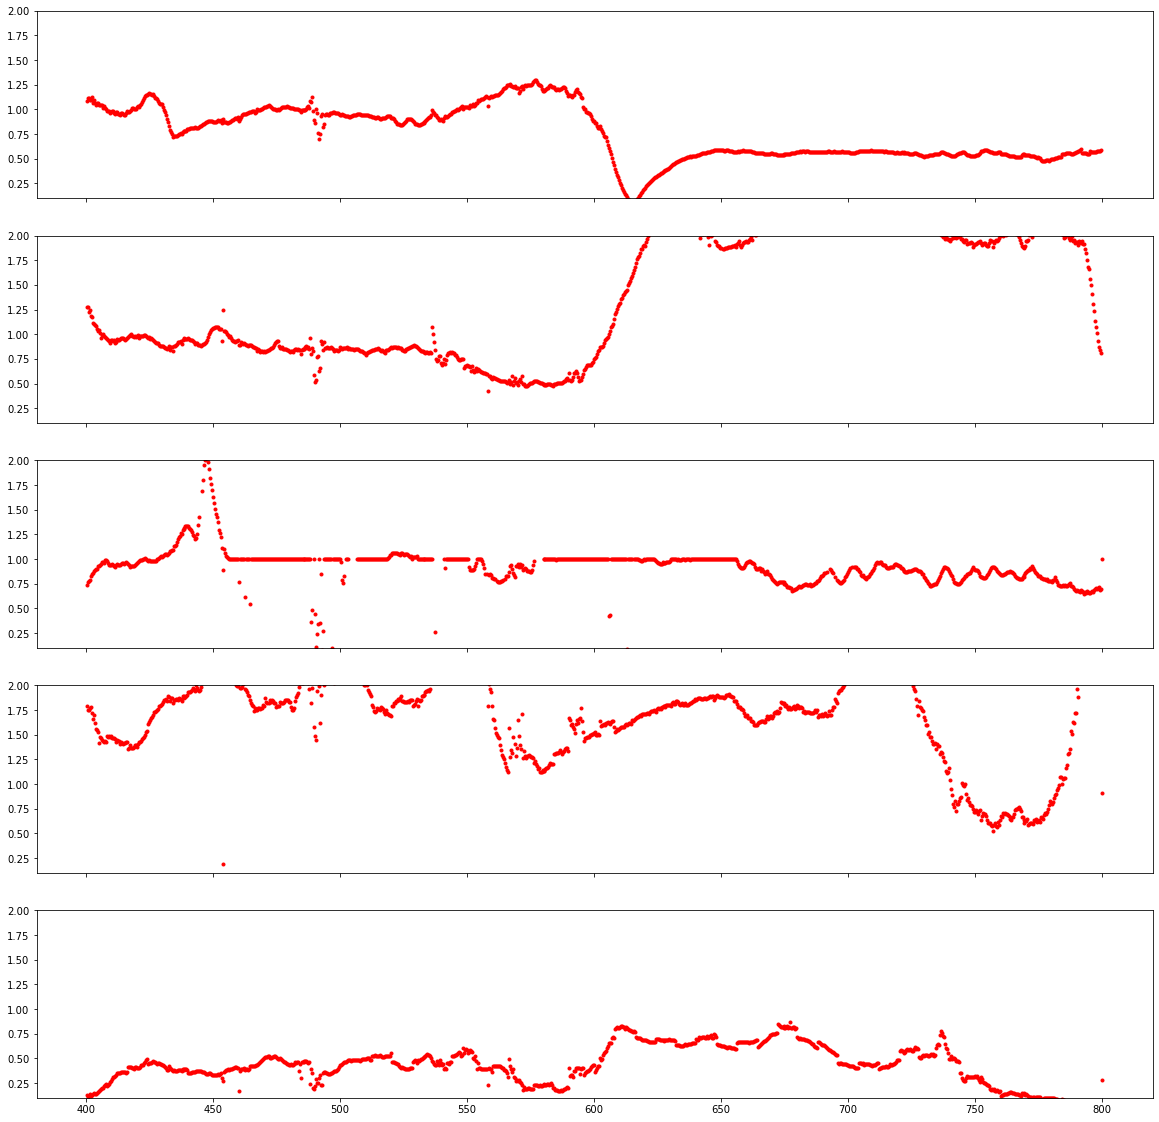

[0.70679313 0.24270324 1.04673072 0.17189209 0.21647166] [0.61925763 0.24232239 2.         0.38160273 0.07647478]


In [34]:
fig,axs = plt.subplots(5, sharex=True,sharey=True,figsize=(20,20))
#for fi in np.arange(len(fits[:,0,0,0])): # fit param
fi = 0
k = 0#4
lp = 1
badfreqs=[]

for p,chind in enumerate(E_pols):
    esig = fits[fi,k,chind,:]
    nsig = fits[fi,k,chind+1,:]
    rat = esig/nsig
    #axs[p].plot(freqs,np.degrees(esig),
    #              color='black',marker='.',linestyle='None')
    #axs[p].plot(freqs,np.degrees(nsig),
    #              color='red',marker='.',linestyle='None')
    axs[p].plot(freqs,rat,
                  color='red',marker='.',linestyle='None')
    #axs[p].set_xlim(400,450)
plt.ylim(0.1,2.0)
plt.show()

find = 900
print(fits[fi,k,N_pols,find],fits[fi,k,E_pols,find])

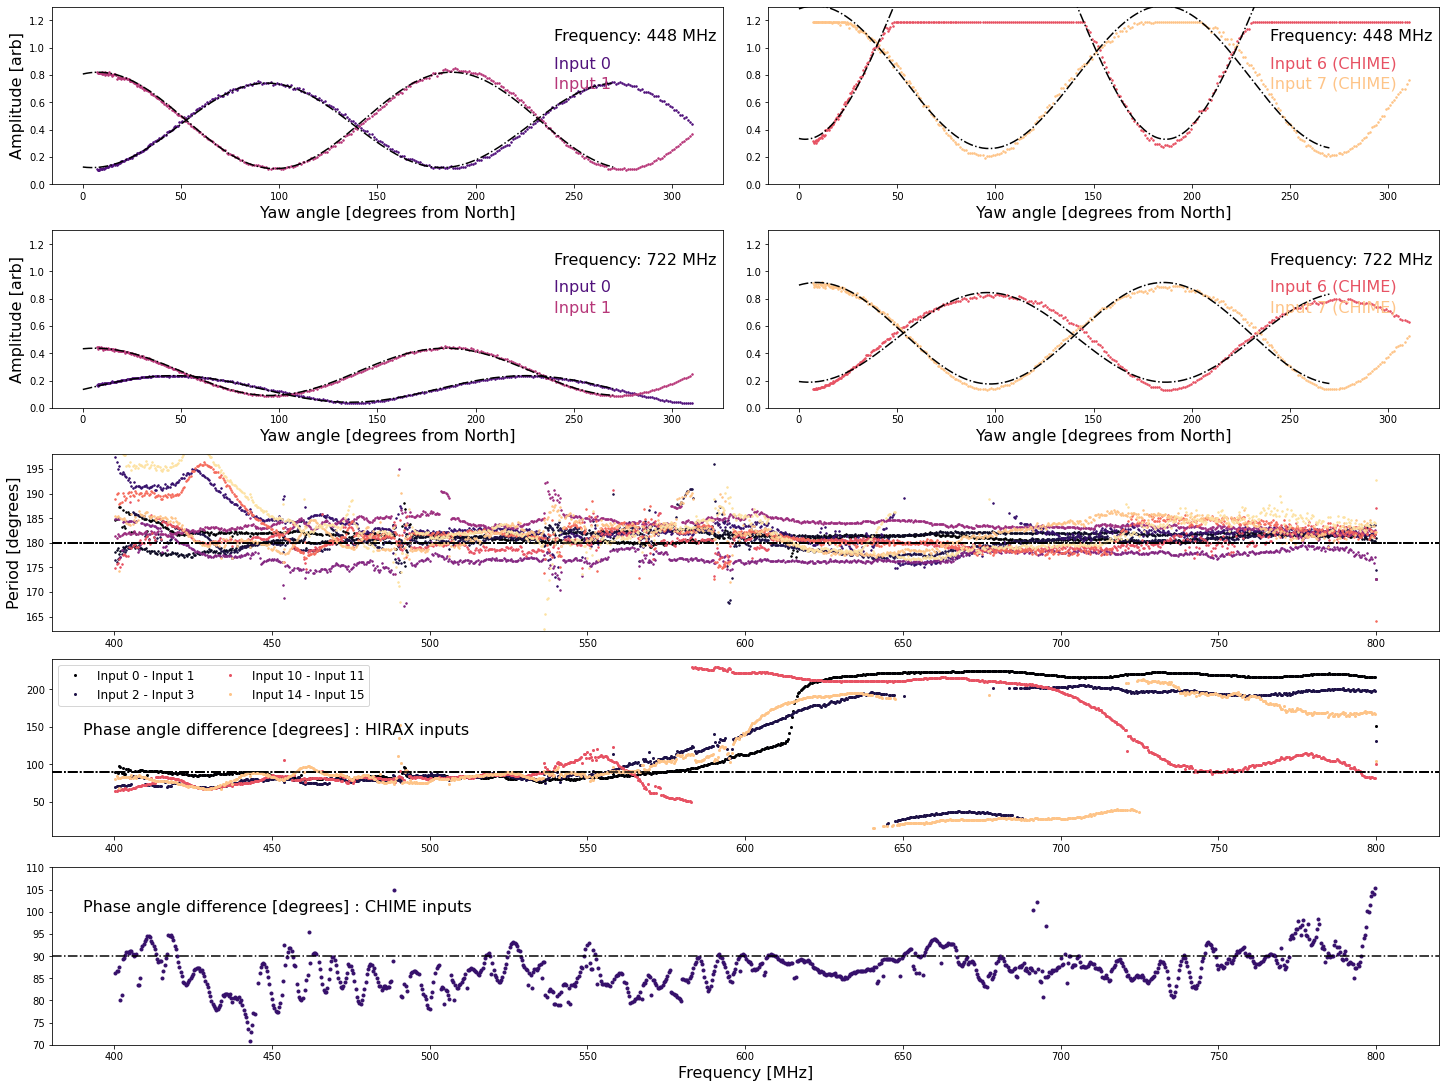

In [20]:
colorz=pu.cm_to_discrete(ccm,16)
fi = 2
k = 0#4
lp = 1


fig = plt.figure(constrained_layout=True,figsize=(20,15))

gs = GridSpec(5, 2, figure=fig)
axs0 = fig.add_subplot(gs[0, 0])
axs1 = fig.add_subplot(gs[1, 0])
axs2 = fig.add_subplot(gs[0, 1])
axs3 = fig.add_subplot(gs[1, 1])
axs4 = fig.add_subplot(gs[2, :])
axs5 = fig.add_subplot(gs[3, :])
axs6 = fig.add_subplot(gs[4, :])



find = 900
chind1 = 0
chind2 = 1
axs0.plot(shiftedyaw[poss[k]], 
            1e7*(concattest.V[poss[k],find,chind1]), '.', 
                    markersize = 3,color=colorz[4],label='input '+str(chind1))
axs0.plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],find,chind2]), '.', 
                      markersize = 3,color=colorz[8],label='input '+str(chind2))
popt1 = fits[:,k,chind1,find]
axs0.plot(np.linspace(0,270,270), cos2_fun(np.linspace(0,270,270), *popt1), color='black',linestyle='-.')
popt1 = fits[:,k,chind2,find]
axs0.plot(np.linspace(0,270,270), cos2_fun(np.linspace(0,270,270), *popt1), color='black',linestyle='-.')

find = 200
axs1.plot(shiftedyaw[poss[k]], 
            1e7*(concattest.V[poss[k],find,chind1]), '.', 
                    markersize = 3,color=colorz[4],label='input '+str(chind1))
axs1.plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],find,chind2]), '.', 
                      markersize = 3,color=colorz[8],label='input '+str(chind2))
popt1 = fits[:,k,chind1,find]
axs1.plot(np.linspace(0,270,270), cos2_fun(np.linspace(0,270,270), *popt1), color='black',linestyle='-.')
popt1 = fits[:,k,chind2,find]
axs1.plot(np.linspace(0,270,270), cos2_fun(np.linspace(0,270,270), *popt1), color='black',linestyle='-.')

find = 900
chind1 = 6
chind2 = 7
axs2.plot(shiftedyaw[poss[k]], 
            1e7*(concattest.V[poss[k],find,chind1]), '.', 
                    markersize = 3,color=colorz[10],label='input '+str(chind1))
axs2.plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],find,chind2]), '.', 
                      markersize = 3,color=colorz[14],label='input '+str(chind2))
popt1 = fits[:,k,chind1,find]
axs2.plot(np.linspace(0,270,270), cos2_fun(np.linspace(0,270,270), *popt1), color='black',linestyle='-.')
popt1 = fits[:,k,chind2,find]
axs2.plot(np.linspace(0,270,270), cos2_fun(np.linspace(0,270,270), *popt1), color='black',linestyle='-.')

find = 200
axs3.plot(shiftedyaw[poss[k]], 
            1e7*(concattest.V[poss[k],find,chind1]), '.', 
                    markersize = 3,color=colorz[10],label='input '+str(chind1))
axs3.plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],find,chind2]), '.', 
                      markersize = 3,color=colorz[14],label='input '+str(chind2))
popt1 = fits[:,k,chind1,find]
axs3.plot(np.linspace(0,270,270), cos2_fun(np.linspace(0,270,270), *popt1), color='black',linestyle='-.')
popt1 = fits[:,k,chind2,find]
axs3.plot(np.linspace(0,270,270), cos2_fun(np.linspace(0,270,270), *popt1), color='black',linestyle='-.')


for p,chind in enumerate(allgoodpols):
    axs4.plot(freqs,180*fits[1,0,chind,:],color=colorz[chind],marker='.',
                markersize=3,linestyle='None')
    axs4.set_ylim(0.9*180,1.1*180)
    axs4.axhline(1.0*180,color='black',linestyle='-.')


for p,chind in enumerate([0,2,10,14]):
    esig = fits[fi,k,chind,:]
    nsig = fits[fi,k,chind+1,:]
    diff = (180/np.pi)*(esig-nsig)+180

    for i in np.arange(0,1024):
        if diff[i] > 230: diff[i] = diff[i]-180
        if diff[i] > 100: badfreqs.append(i)
    axs5.plot(freqs,diff,
                 color=colorz[chind],marker='.',
                markersize=4,linestyle='None',label='Input '+str(chind)+' - Input '+str(chind+1))
    axs5.axhline(90,color='black',ls='-.')
chind = 6
esig = fits[fi,k,chind,:]
nsig = fits[fi,k,chind+1,:]
diff = (180/np.pi)*(esig-nsig)+180

for i in np.arange(0,1024):
    if diff[i] > 230: diff[i] = diff[i]-180
    if diff[i] > 100: badfreqs.append(i)
axs6.plot(freqs,diff,
                 color=colorz[p],marker='.',linestyle='None',label='Input '+str(chind)+' - Input '+str(chind+1))
axs6.axhline(90,color='black',ls='-.')
    
axs0.text(240,1.05,'Frequency: 448 MHz',fontsize=16)
axs0.text(240,0.85,'Input 0',color=colorz[4],fontsize=16)
axs0.text(240,0.7,'Input 1',color=colorz[8],fontsize=16)
axs0.set_xlabel('Yaw angle [degrees from North]',fontsize=16)
axs0.set_ylabel('Amplitude [arb]',fontsize=16)
axs0.set_ylim(0,1.3)

axs1.text(240,1.05,'Frequency: 722 MHz',fontsize=16)
axs1.text(240,0.85,'Input 0',color=colorz[4],fontsize=16)
axs1.text(240,0.7,'Input 1',color=colorz[8],fontsize=16)
axs1.set_xlabel('Yaw angle [degrees from North]',fontsize=16)
axs1.set_ylabel('Amplitude [arb]',fontsize=16)
axs1.set_ylim(0,1.3)

axs2.text(240,1.05,'Frequency: 448 MHz',fontsize=16)
axs2.text(240,0.85,'Input 6 (CHIME)',color=colorz[10],fontsize=16)
axs2.text(240,0.7,'Input 7 (CHIME)',color=colorz[14],fontsize=16)
axs2.set_xlabel('Yaw angle [degrees from North]',fontsize=16)
axs2.set_ylim(0,1.3)

axs3.text(240,1.05,'Frequency: 722 MHz',fontsize=16)
axs3.text(240,0.85,'Input 6 (CHIME)',color=colorz[10],fontsize=16)
axs3.text(240,0.7,'Input 7 (CHIME)',color=colorz[14],fontsize=16)
axs3.set_xlabel('Yaw angle [degrees from North]',fontsize=16)
axs3.set_ylim(0,1.3)

#axs4.set_xlabel('Frequency [MHz]',fontsize=16)
axs4.set_ylabel('Period [degrees]',fontsize=16)

#axs5.set_xlabel('Frequency [MHz]',fontsize=16)
axs5.text(390,140,'Phase angle difference [degrees] : HIRAX inputs',fontsize=16)
axs5.legend(ncol=2,fontsize=12)

axs6.set_xlabel('Frequency [MHz]',fontsize=16)
axs6.text(390,100,'Phase angle difference [degrees] : CHIME inputs',fontsize=16)
axs6.set_ylim(70,110)

plt.show()
fig.clf()

In [38]:
## This fits all positions
poss = [pos0,pos1,pos2,pos3,pos4]
lp = 5
fits = np.zeros((4,5,16,1024))
#bnds = ((0, 0.5,-np.pi, -np.inf),(2.0, 1.5,np.pi, np.inf)) # force amplitude to be positive, maybe makes the fits take forver

for fi,find in enumerate(np.arange(0,1024)):
    for p,chind in enumerate(allgoodpols):
    #for p,chind in enumerate(chimepols):
        for k in np.arange(lp):
            try:
                gi = np.where(1e7*(concattest.V[poss[k],find,chind]) < 1.19)[0]
                popt, pcov = opt.curve_fit(cos2_fun, shiftedyaw[poss[k][gi]], \
                        1e7*(concattest.V[poss[k][gi],find,chind]), p0=pG,bounds=bnds)
                fits[:,k,chind,find] = popt
            except:''
        

/home/ln267/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(400, 175, 'CHIME FEED')

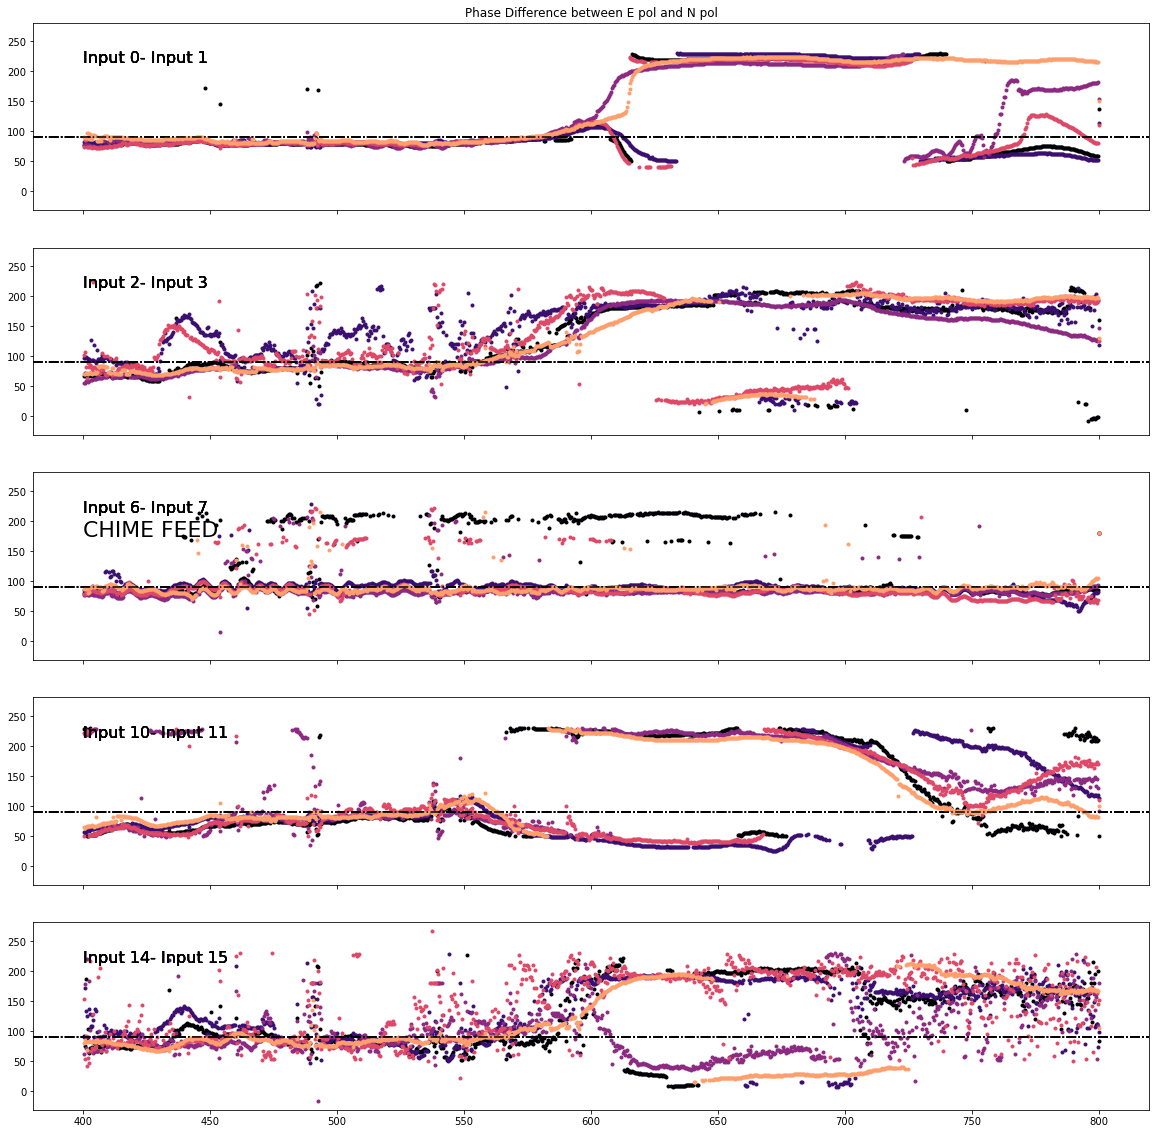

In [39]:
# plot the same as above but for all locations and see what happens:

fig,axs = plt.subplots(5, sharex=True,sharey=True,figsize=(20,20))
#for fi in np.arange(len(fits[:,0,0,0])): # fit param
fi = 2


for p,chind in enumerate(E_pols):
    for k in np.arange(lp):
        esig = fits[fi,k,chind,:]
        nsig = fits[fi,k,chind+1,:]
        diff = (180/np.pi)*(esig-nsig)+180
        for i in np.arange(0,1024):
            if diff[i] > 230: diff[i] = diff[i]-180
        axs[p].plot(freqs,diff,
                  color=colorz[k],marker='.',linestyle='None')
        #axs[p].set_ylim(0,4.5)
        axs[p].text(400,215,'Input '+str(chind)+'- Input '+str(chind+1),fontsize=16)
        axs[p].axhline(90,color='black',ls='-.')
        #axs[p].axhline(0.0,color='yellow')
axs[0].set_title('Phase Difference between E pol and N pol')
axs[2].text(400,175,'CHIME FEED',fontsize=22)

In [ ]:
# Look at Amplitude
titles=['Amplitude','Period','Phase','Offset']
fig,axs = plt.subplots(10, sharex=True,figsize=(20,20))
#for fi in np.arange(len(fits[:,0,0,0])): # fit param
fi = 0
for p,chind in enumerate(allgoodpols):
    for k in np.arange(lp):
        axs[p].plot(freqs,fits[fi,k,chind,:],color=colorz[k])
        axs[p].set_ylim(0,0.9)
        axs[p].text(400,0.5,'Input '+str(chind))
axs[0].set_title(titles[fi])
    
fig.show() 


In [ ]:
# Look at Period

fig,axs = plt.subplots(10, sharex=True,figsize=(20,20))
#for fi in np.arange(len(fits[:,0,0,0])): # fit param
fi = 1
for p,chind in enumerate(allgoodpols):
    for k in np.arange(lp):
        axs[p].plot(freqs,fits[fi,k,chind,:],color=colorz[k])
        axs[p].set_ylim(0.9,1.1)
        axs[p].text(400,0.95,'Input '+str(chind))
        axs[p].axhline(1.0,color='yellow')
axs[0].set_title(titles[fi])
    
fig.show()

In [ ]:
# Look at Phase

fig,axs = plt.subplots(10, sharex=True,figsize=(20,20))
#for fi in np.arange(len(fits[:,0,0,0])): # fit param
fi = 2
for p,chind in enumerate(allgoodpols):
    for k in np.arange(lp):
        axs[p].plot(freqs,(180/np.pi)*fits[fi,k,chind,:],color=colorz[k])
        #axs[p].set_ylim(0,4.5)
        axs[p].text(400,-1,'Input '+str(chind))
        #axs[p].axhline(0.0,color='yellow')
axs[0].set_title(titles[fi])
    
fig.show()

In [ ]:
# Look at offset

fig,axs = plt.subplots(10, sharex=True,figsize=(20,20))
#for fi in np.arange(len(fits[:,0,0,0])): # fit param
fi = 3
for p,chind in enumerate(allgoodpols):
    for k in np.arange(lp):
        axs[p].plot(freqs,fits[fi,k,chind,:],color=colorz[k])
        axs[p].set_ylim(0,0.9)
        #axs[p].text(400,0.5,'Input '+str(chind))
axs[0].set_title(titles[fi])
    
fig.show()

In [ ]:
# Look at the CHIME feeds specifically first

# Lets try fitting a sine to the CHIME inputs, we'll start with position 4

poss = [pos4]
find = 200
chind1 = 6
chind2 = 7
fi = 2

 
plt.plot(freqs,(180/np.pi)*np.abs((fits[fi,k,chind1,:] - fits[fi,k,chind2,:])),marker='.',linestyle='None',color='red')
plt.show()



In [ ]:
# Look at Phase

fig,axs = plt.subplots(5, sharex=True,figsize=(20,20))
#for fi in np.arange(len(fits[:,0,0,0])): # fit param
fi = 2
k = 1#4
poss = [pos0,pos1,pos2,pos3,pos4]
pl = ['0','1','2','3','4']
lp = 5

for p,chind in enumerate(E_pols):
    for k in [4]:#[1,2,4]:
        axs[p].plot(freqs,(180/np.pi)*np.abs((fits[fi,k,chind,:]-fits[fi,k,chind+1,:])),
                    color=colorz[k],label='Pos '+pl[k])
        #axs[p].set_ylim(0,4.5)
        axs[p].text(400,150,'Input '+str(chind)+'- Input '+str(chind+1))
        axs[p].legend()
        axs[p].axhline(90,color='black',ls='-.')
        #axs[p].axhline(0.0,color='yellow')
axs[0].set_title('Phase Difference between E pol and N pol')
axs[2].text(400,25,'CHIME FEED',fontsize=22)
    
fig.show()

In [ ]:
# From the above:


# Suggest we first restrict ourselves to the best SNR location, loc 4

poss = [pos4]
lp = 1

for i, find in enumerate(np.arange(1000,0,-128)): 
    fig,axs = plt.subplots(2,5, sharex=True,figsize=(10,8))
    for p,chind in enumerate(N_pols):
        for k in np.arange(lp):
            
            #try:
                gi = np.where(1e7*(concattest.V[poss[k],find,chind]) < 1.191)[0]
                popt, pcov = opt.curve_fit(cos2_fun, shiftedyaw[poss[k][gi]], \
                        1e7*(concattest.V[poss[k][gi],find,chind]), p0=[0.1,1.0,0,0.5])
                #print('newfit ',find,chind,k,popt)
                #print('old fit was ',fits[:,k,chind,find])
                axs[0,p].plot(np.linspace(0,360,360), cos2_fun(np.linspace(0,360,360), *popt), 'r')
                axs[0,p].plot(shiftedyaw[poss[k][gi]], 
                1e7*(concattest.V[poss[k][gi],find,chind]), '.', 
                      markersize = 2,color=colorz[k],label='loc'+str(k))
            #except:''
            #axs[0,p].set_title('Input '+str(chind))
    for p,chind in enumerate(E_pols):
        for k in np.arange(lp):
            
            try:
                gi = np.where(1e7*(concattest.V[poss[k],find,chind]) < 1.191)[0]
                popt, pcov = opt.curve_fit(cos2_fun, shiftedyaw[poss[k][gi]], \
                        1e7*(concattest.V[poss[k][gi],find,chind]), p0=[0.1,1,0,0.5])
                #print('new fit ',find,chind,k,popt)
                #print('old fit was ',fits[:,k,chind,find])
                axs[1,p].plot(np.linspace(0,360,360), cos2_fun(np.linspace(0,360,360), *popt), 'r')
                axs[1,p].plot(shiftedyaw[poss[k][gi]], 
                1e7*(concattest.V[poss[k][gi],find,chind]), '.', 
                      markersize = 2,color=colorz[k],label='loc'+str(k))
            except:''
            axs[1,p].set_title('Input '+str(chind))
    fig.suptitle('FREQUENCY '+str(freqs[find]))

    fig.show()

In [ ]:

poss = [pos4]
lp = 1
k=0
find = 900
chind1 = 6
chind2 = 7



plt.plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],find,chind1]), '.', 
                      markersize = 2,color=colorz[k])
A = fits[0,4,chind1,find]
B = fits[1,4,chind1,find]
C = fits[2,4,chind1,find]
D = fits[3,4,chind1,find]
print(fits[:,4,chind1,find])

xes = np.arange(0,2*np.pi,0.01)
ff = np.abs(A*np.cos(B*(xes - C)) + D)
plt.plot(np.degrees(xes),ff)

# Play around here

a = A+D
b = B/2
c = C
d = 0.1*A
fff = a*(np.cos(b*(xes - c)))**2 + d

plt.plot(np.degrees(xes),fff,color='red')
plt.show()

In [ ]:
## Let's plot the phase and period for two CHIME feeds:

fig,axs = plt.subplots(3,2,figsize=(20,20))
poss = [pos4]
lp = 1
k=0
find = 900
chind1 = 6
chind2 = 7



axs[0,0].plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],find,chind1]), '.', 
                      markersize = 2,color=colorz[k])
A = fits[0,4,chind1,find]
B = fits[1,4,chind1,find]
C = fits[2,4,chind1,find]
D = fits[3,4,chind1,find]
print(fits[:,4,chind1,find])

xes = np.arange(0,2*np.pi,0.01)
ff = np.abs(A*np.cos(B*(xes - C)) + D)
axs[0,0].plot(np.degrees(xes),ff)

a = A
b = B
c = C+np.pi
d = D
fff = a*np.abs(np.cos(b*(xes - c))) + d

axs[0,0].plot(np.degrees(xes),fff,color='red')



axs[0,1].plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],find,chind2]), '.', 
                      markersize = 2,color=colorz[k])
#A = 1.0
#B = 1.0
#C = np.pi/2
#D = 0.0
#ff = np.abs(A*np.cos(B*(xes - C)) + D)
#axs[0,1].plot(np.degrees(xes),ff)


axs[1,0].plot(freqs,fits[1,k,chind1,:],color=colorz[k])
axs[1,1].plot(freqs,fits[1,k,chind2,:],color=colorz[k])
axs[1,0].set_ylabel('Period')

axs[2,0].plot(freqs,fits[2,k,chind1,:],color=colorz[k])
axs[2,1].plot(freqs,fits[2,k,chind2,:],color=colorz[k])
axs[2,0].set_ylabel('Phase')

fig.show()

In [ ]:

A = 1.0
B = 1.0
C = np.pi/2
D = 0.0

xes = np.arange(0,2*np.pi,0.01)
ff = A*np.cos(B*(xes - C)) + D
plt.plot(np.degrees(xes),ff,color='blue')

a = A
b = 1.0
c = np.pi/2
d = D


fff = a*np.cos(b*(xes - c))**2 + d




plt.plot(np.degrees(xes),fff,color='red')

In [ ]:
# Lets try fitting a sine to the CHIME inputs, we'll start with position 4

poss = [pos0]
find = 200
chind = 6

plt.plot(shiftedyaw[poss[0]], 
        1e7*(concattest.V[poss[0],find,chind]),marker='.',linestyle='None')

gi = np.where(1e7*(concattest.V[poss[0],find,chind]) < 1.191)[0]
plt.plot(shiftedyaw[poss[0][gi]], 
        1e7*(concattest.V[poss[0][gi],find,chind]),marker='.',linestyle='None')
popt, pcov = opt.curve_fit(cos2_fun, shiftedyaw[poss[0][gi]], \
                               1e7*(concattest.V[poss[0][gi],find,chind]), p0=[0.1,1.0,0,0.1])
print('chind1 ',popt)
plot(np.linspace(0,360,360), cos2_fun(np.linspace(0,360,360), *popt), 'k')


xes = np.arange(0,2*np.pi,0.01)

a = 1.0
b = 1.0
c = 0.0
d = 1.1

fff = a*np.cos(b*(xes - c))**2 + d
plot(np.degrees(xes),fff, 'r')

plt.show()

print('cos sq ', popt)


poss = [pos0]
find = 200
chind = 7

plt.plot(shiftedyaw[poss[0]], 
        1e7*(concattest.V[poss[0],find,chind]),marker='.',linestyle='None')

print(max(1e7*(concattest.V[poss[0],find,chind])))

# For this channel, the max seems to be 1.191

gi = np.where(1e7*(concattest.V[poss[0],find,chind]) < 1.191)[0]

plt.plot(shiftedyaw[poss[0][gi]], 
        1e7*(concattest.V[poss[0][gi],find,chind]),marker='.',linestyle='None')


popt, pcov = opt.curve_fit(cos2_fun, shiftedyaw[poss[0][gi]], \
                               1e7*(concattest.V[poss[0][gi],find,chind]), p0=[0.1,1.0,0,0.1])
plot(np.linspace(0,360,360), cos2_fun(np.linspace(0,360,360), *popt), 'k')
plot(np.linspace(0,360,360), cos2_fun(np.linspace(0,360,360), [1.0,1.0,0.0,0.2]), 'r')

plt.show()

print('cos 2 ',popt)